In [3]:
from typing import Callable
import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np

class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)

In [6]:
def function(nn: NNApproximator, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)


def function_derivative(nn: NNApproximator, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = function(nn, x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def compute_loss(nn: NNApproximator, x: torch.Tensor = None, verbose: bool = False) -> torch.float:
    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """

    interior_loss = function_derivative(nn, x) - R * x * (1 - x)

    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    boundary_loss = function(nn, boundary) - F0
    final_loss = interior_loss.pow(2).mean() + boundary_loss ** 2
    return final_loss


In [7]:
def train_model(
    nn: NNApproximator,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
    ) -> NNApproximator:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:
            loss: torch.Tensor = loss_fn(nn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return nn, np.array(loss_evolution)


def check_gradient(nn: NNApproximator, x: torch.Tensor = None) -> bool:

    eps = 1e-4
    dfdx_fd = (function(nn, x + eps) - function(nn, x - eps)) / (2 * eps)
    dfdx_sample = function_derivative(nn, x, order=1)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)

Epoch: 0 - Loss: 0.576867
Epoch: 1000 - Loss: 0.004365
Epoch: 2000 - Loss: 0.002266
Epoch: 3000 - Loss: 0.000226
Epoch: 4000 - Loss: 0.000192
Epoch: 5000 - Loss: 0.000169
Epoch: 6000 - Loss: 0.000153
Epoch: 7000 - Loss: 0.000140
Epoch: 8000 - Loss: 0.000130
Epoch: 9000 - Loss: 0.000121
Epoch: 10000 - Loss: 0.000114
Epoch: 11000 - Loss: 0.000108
Epoch: 12000 - Loss: 0.000102
Epoch: 13000 - Loss: 0.000096
Epoch: 14000 - Loss: 0.000091
Epoch: 15000 - Loss: 0.000087
Epoch: 16000 - Loss: 0.000082
Epoch: 17000 - Loss: 0.000078
Epoch: 18000 - Loss: 0.000075
Epoch: 19000 - Loss: 0.000071


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


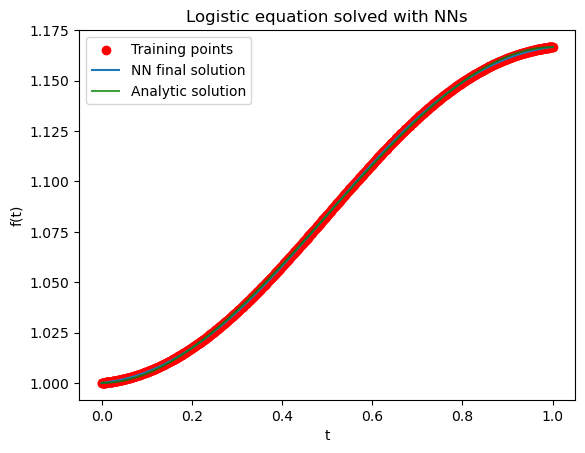

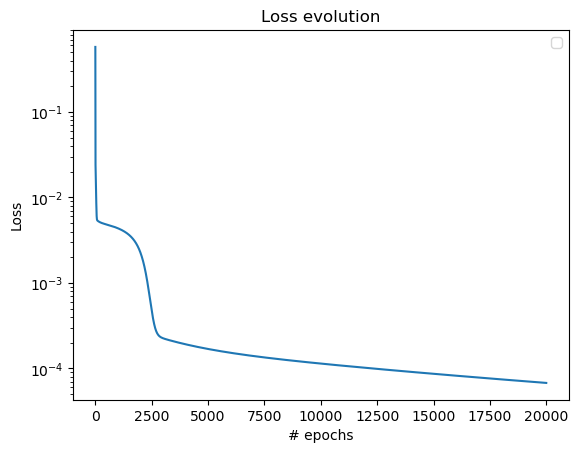

In [8]:
R = 1.0
F0 = 1.0

if __name__ == "__main__":
    from functools import partial

    domain = [0.0, 1.0]
    x = torch.linspace(domain[0], domain[1], steps=1000, requires_grad=True)
    x = x.reshape(x.shape[0], 1)

    nn_approximator = NNApproximator(4, 10)
    assert check_gradient(nn_approximator, x)

    # train the PINN
    loss_fn = partial(compute_loss, x=x, verbose=True)
    nn_approximator_trained, loss_evolution = train_model(
        nn_approximator, loss_fn=loss_fn, learning_rate=0.1, max_epochs=20_000
    )

    x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

    # numeric solution
    def logistic_eq_fn(x, y):
        return R * x * (1 - x)

    numeric_solution = solve_ivp(
        logistic_eq_fn, domain, [F0], t_eval=x_eval.squeeze().detach().numpy()
    )
    
    # plotting
    fig, ax = plt.subplots()

    f_final_training = function(nn_approximator_trained, x)
    f_final = function(nn_approximator_trained, x_eval)

    ax.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points", color="red")
    ax.plot(x_eval.detach().numpy(), f_final.detach().numpy(), label="NN final solution")
    ax.plot(
        x_eval.detach().numpy(),
        numeric_solution.y.T,
        label=f"Analytic solution",
        color="green",
        alpha=0.75,
    )
    ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
    ax.legend()

    fig, ax = plt.subplots()
    ax.semilogy(loss_evolution)
    ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
    ax.legend()

    plt.show()